# Learning to map in R!

I learned `ggmap` a couple years back, but never got beyond making a couple extremely basic maps.  There's more to learn -- experimenting in a notebook seems like a viable approach.  I need to talk (type) out my ideas, and the code needs to, well... map.

### Data

I need some geographical data to represent on a map.  A brief Google search yielded a [JSON file](https://gist.github.com/Miserlou/c5cd8364bf9b2420bb29) giving coordinates, population, and growth rates for the 1000 most populous cities in the United States.  A quick download, and I've got my data! Hat tip to [Rich Jones](https://gist.github.com/Miserlou).

### Importing Data

Ok, I learned once before JSON is some sort of data structure.  JSON vs. XML vs. XLSX vs. data frames... I have no ideas about the differences between them all.  But, I figured one can convert to the other.  So, Google "JSON to data frame R" and without clicking any results, I could see my end game: `jsonlite` package, and a `fromJSON` command.

In [12]:
#---import data from 1000 most populous US cities in 2013
require(jsonlite)
fromJSON("cities.json")->dat

#---preview
head(dat)

city,growth_from_2000_to_2013,latitude,longitude,population,rank,state
New York,4.8%,40.71278,-74.00594,8405837,1,New York
Los Angeles,4.8%,34.05223,-118.24368,3884307,2,California
Chicago,-6.1%,41.87811,-87.62980,2718782,3,Illinois
Houston,11.0%,29.76043,-95.36980,2195914,4,Texas
Philadelphia,2.6%,39.95258,-75.16522,1553165,5,Pennsylvania
Phoenix,14.0%,33.44838,-112.07404,1513367,6,Arizona


There's some fun numbers in there that I'll revisit later (growth rate!!).  But, for now, I want to get those cities on a basic US map.

Googling "ggplot map" and I find a [tidy little tutorial](https://eriqande.github.io/rep-res-web/lectures/making-maps-with-R.html) that just might be my crutch for the rest of this coding session.  Of course, I'm not interested in going through the tutorial step-by-step.  But, I'll steal some chunks of it, deduce what's going on, and then bend it back to my data frame.  Hat tip to [Eric Anderson](https://eriqande.github.io)!

First and foremost, though:  looks like there's a few libraries I need handy:  `ggplot2`, `ggmap`, `maps`, `mapdata`.

In [2]:
#---get map data
library(ggplot2)
library(ggmap)
library(maps)
library(mapdata)

Okay, first code snippet I'll steal from the tutorial:

`usa <- map_data("usa")
ggplot() + geom_polygon(data = usa, aes(x=long, y = lat, group = group)) + 
  coord_fixed(1.3)`
  
Looks like `map_data` is importing a map, which then is represented using the `geom_polygon` call.  Ok -- though I would want to examine the structure of `usa` also.  

And, you know, I've never used `coord_fixed` before.  Tutorial tells me it's fixing the aspect ratio.  I figure I would have come across that before, or at least have searched it out myself.  Creating basketball shot charts, fixing the aspect ratio for the court would (obviously) be remarkably important.

long,lat,group,order,region,subregion
-101.4078,29.74224,1,1,main,NA
-101.3906,29.74224,1,2,main,NA
-101.3620,29.65056,1,3,main,NA
-101.3505,29.63911,1,4,main,NA
-101.3219,29.63338,1,5,main,NA
-101.3047,29.64484,1,6,main,NA


[1] 7243

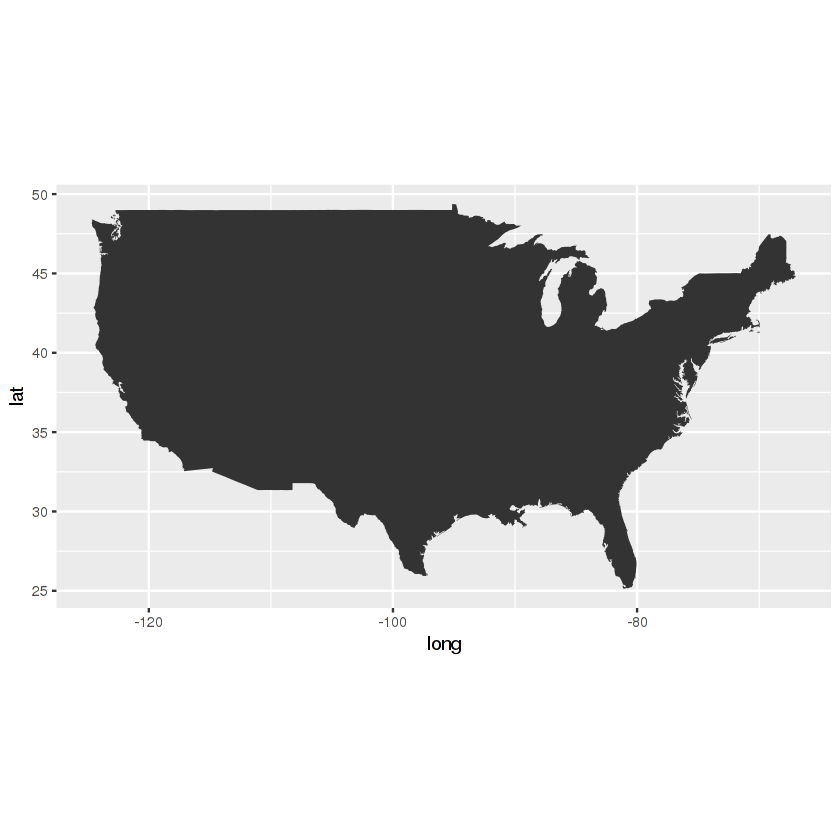

In [15]:
usa <- map_data("usa")
#---what's a map_data output look like?
head(usa)
nrow(usa)

#---ggplot!!!
ggplot() +
    #---the map is a polygon...
    geom_polygon(
        #---with usa data
        data = usa, 
        #---aesthetics!!
        aes(
            #---lat & long coordinates
            x=long, 
            y = lat, 
            #---okay I need to remember how to use 'group'
            group = group)
    ) + 
#---fix aspect ratio!  1.3 : 1 , y: x
  coord_fixed(1.3)

Okay!  I get it -- the points are plotted (x and y aesthetics) and `geom_polygon` aims to connect these dots and fill them in... but it's got to connect and group the dots properly.  Hence the `group` aesthetic:  it's telling `geom_polygon` which dots to group together.  So, there must be different values for `usa$group` for the teeny islands in Puget Sound, or Nantucket, or Long Island.

In particular, running `unique(usa$group)` tells me there's TEN different groups, or there's ten different landforms to represent -- I suppose that'd be nine notable islands and the US mainland.  Wonder how Alaska and Hawaii (and Puerto Rico!) feel about that...

### A couple solo maps

Yeah, I was going to plot those 1000 most populous cities.  I'll get to it.  But I'm awfully intrigued by the `map_data` command.  Obviously I could go all day learning about that.  But,  given the structure of the output (lots of x-y coordinates marking a boundary) could I represent using other geometries, instead of `geom_polygon`?  Let's try, using Illinois.

In [7]:
#---get map data for all 50 states
states<-map_data("state")

#---subset just Illinois data
IL<-subset(states,region=="illinois")
#head(IL)

A couple realizations as I worked through that:  `map_data` doesn't give individual state data; I need to get all 50 states and then subset.  (Maybe there's a way... that's for another time)  Another realization:  the `order` column doesn't re-start for each region; so with some crafty code, I could draw the entire 50 states sequentially...

In [18]:
#---ggplot base map for Illinois!
map.base<-ggplot(
    #---let's represent Illinois!!
    data=IL,
    #0--aesthetics -- lat and long
    aes(
        #---careful... x= long, y=lat
        x=long,
        y=lat
    )
)+
#---don't mess with that aspect ratio!!!
coord_fixed()

Careful: `x` is longitude, `y` is latitude...  Rookie mistake.

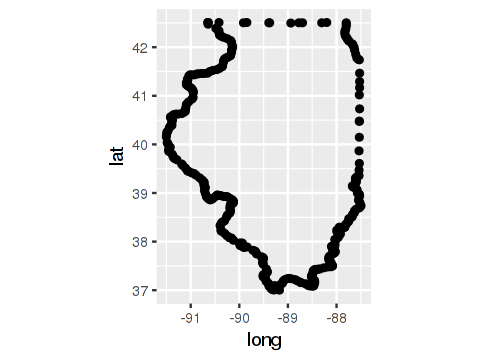

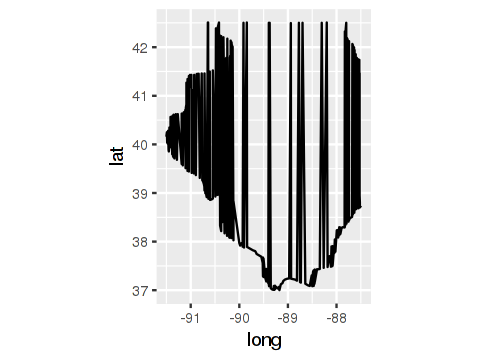

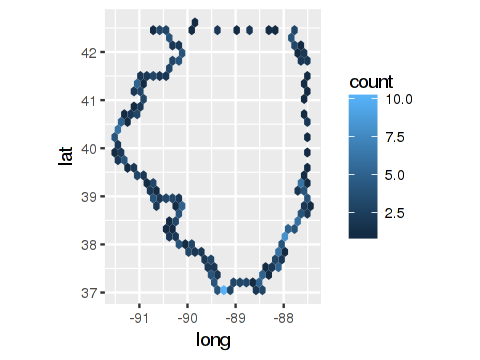

In [26]:
############################################
#---represent it with various geometries...

#---had to dig to find out how to resize plots in a notebook...
options(
    repr.plot.width=4, 
    repr.plot.height=3
)

#---behaved as expected.
map.base+geom_point()

#---not what I expected, at all!!  Super cool, though--but I wonder why it's doing that.
map.base+geom_line()

#---HA! lighter-colored hexagons have more 'wavey' regions of the state border.  
map.base+geom_hex()

Whoa!  The first map is pretty straightforward.  The second one -- I love it!  But, I don't understand why the line is out of order.  I'll have to investigate the `geom_line` geometry to see if there's a straightforward way to control the order the line is drawn.  The third is a goofy little experiment:  how wavey is the border near where you live?  

Probably most notably, [I found out how to resize plots in a Jupyter notebook](https://blog.revolutionanalytics.com/2015/09/resizing-plots-in-the-r-kernel-for-jupyter-notebooks.html); the huge plots seemed way to big.  On a tiny chromebook I couldn't view the whole map without scrolling.

Now, I'm going to find out what's up with the order `geom_line` draws.  I know [where](https://ggplot2.tidyverse.org/reference/index.html#section-layer-geoms) I can find some information.... Without even clicking on `geom_line` I figured it out.  There's a difference between `geom_line` and `geom_path`.  Let's see:

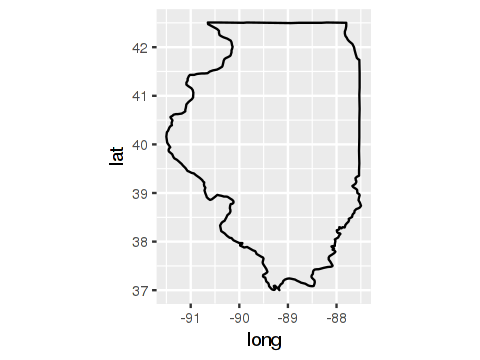

In [24]:
map.base+geom_path()

Yep!  If I had slowed down to read THE FIRST TWO SENTENCES on the [help page](https://ggplot2.tidyverse.org/reference/geom_path.html) I would have known the issue.  But -- purposely substituting `path` with `line` does offer some potential artistic representations.  I recognize where `geom_line` would be helpful for, say, time-sequenced data if the observations are not ordered in the data frame.  It'll do that ordering for you.

To that end:  what if the ordering was purposefully scrambled??

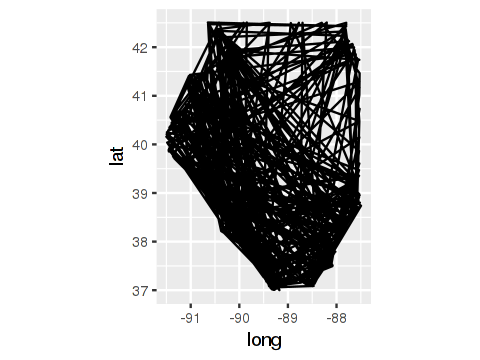

In [27]:
#---scramble the dots in the Illinois data frame
IL2<-IL[sample(1:nrow(IL)),]

#---plot!
ggplot(
    #---let's represent scrambled Illinois!!
    data=IL2,
    #0--aesthetics -- lat and long
    aes(
        #---careful... x= long, y=lat
        x=long,
        y=lat
    )
)+
#---don't mess with that aspect ratio!!!
coord_fixed()+
#---line, err path geometry
geom_path()

Not bad -- but, what about other states using this model?  Let's randomly select one of the US states, then scramble the dots of the border, then connect the dots to draw a map.  No name given -- I wonder if I'll be able to tell what state it is??

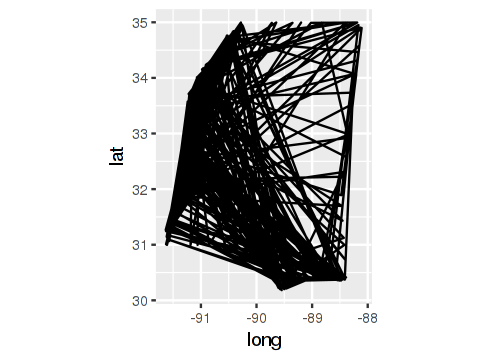

In [30]:
#---find all the states available to me, then pick one at random
state.names<-unique(states$region)
sample(state.names,1)->secret.state

#---extract border data for my 'secret state'
secret.state.border<-subset(states,region==secret.state)

#---scramble that data
secret.state.border<-secret.state.border[sample(1:nrow(secret.state.border)),]

#---plot!
ggplot(
    #---let's represent scrambled Illinois!!
    data=secret.state.border,
    #0--aesthetics -- lat and long
    aes(
        #---careful... x= long, y=lat
        x=long,
        y=lat
    )
)+
#---don't mess with that aspect ratio!!!
coord_fixed()+
#---line, err path geometry
geom_path()


Whoa!  I think I just discovered a game that needs to happen.  So -- I'll get back to that JSON data with the 1000 cities...  but I'm gonna riff on this for now.  To be continued...